## Import data, set logging level

In [1]:
from mne.datasets import multimodal
import mne
mne.set_log_level(verbose='CRITICAL')
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg
from deepmeg.training.trainers import Trainer
from deepmeg.data.datasets import read_epochs_dataset, EpochsDataset
from deepmeg.preprocessing.transforms import zscore
import torch
import torch.nn as nn
from collections import defaultdict
from deepmeg.data.utils import make_train_and_val_loaders
from torch.utils.data import DataLoader, Dataset
from deepmeg.models.interpretable import LFCNN
from deepmeg.interpreters import LFCNNInterpreter
import torchmetrics
from deepmeg.training.callbacks import PrintingCallback
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import matplotlib
import scipy as sp
import pandas as pd

# very simple function to plot history of the model training

def plot_metrics(metrics: dict[str, np.ndarray]):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()


import matplotlib as mpl
import argparse
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
import numpy as np
import pandas as pd
from time import perf_counter
import re
import logging
import matplotlib.pyplot as plt
import scipy
import torch
from deepmeg.data.datasets import EpochsDataset
from deepmeg.utils.params import LFCNNParameters
from deepmeg.experimental.params import SPIRITParameters
from deepmeg.preprocessing.transforms import zscore
import scipy as sp

def set_ticks_invisible(ax, side='x'):
    if side == 'x':
        axis = ax.xaxis
    elif side == 'y':
        axis = ax.yaxis
    else:
        raise ValueError(f'Incorret side "{side}", use x or y only')
    for tick in axis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
        tick.label1.set_visible(False)
        tick.label2.set_visible(False)


def gaussian_random_walk(n: int, stepsize: float = 1.0) -> np.ndarray:
    # Generate random steps using a Gaussian distribution
    steps = np.random.normal(loc=0, scale=stepsize, size=(n, 2))

    # Compute the coordinates of the random walk by cumulatively summing the steps
    walk = np.cumsum(steps, axis=0)

    return walk.T[0]

def sample_spherical(x, y, z):
    vec = np.stack([x, y, z], axis=0)
    vec /= np.linalg.norm(vec, axis=0)
    return vec


def plot_latent_space(
    latent1: np.ndarray,
    latent2: np.ndarray,
    latent3: np.ndarray,
    target: np.ndarray
):

    assert len({len(i) for i in (latent1, latent2, latent3)}) == 1, f'given latent variables hase different samplings1: {len(latent1)}, {len(latent2)}, {len(latent3)}'
    assert len(target) == len(latent1), f'Target variable course has different sampling: {len(target)} ~ {len(latent1)}'

    xx, yy, zz = sample_spherical(latent1, latent2, latent3)

    fig = plt.figure()
    sfig1, sfig2 = fig.subfigures(1, 2, wspace=0.07)

    gs1 = sfig1.add_gridspec(3, 5)
    gs2 = sfig2.add_gridspec(5, 5)

    ax1 = sfig1.add_subplot(gs1[0, :])
    ax2 = sfig1.add_subplot(gs1[1, :])
    ax3 = sfig1.add_subplot(gs1[2, :])

    ax1.plot(target, latent1)
    ax1.set_ylabel('latent 1')
    set_ticks_invisible(ax1)
    ax2.plot(target, latent2)
    ax2.set_ylabel('latent 2')
    set_ticks_invisible(ax2)
    ax3.plot(target, latent3)
    ax3.set_ylabel('latent 3')
    ax3.set_xlabel('time')

    ax4 = sfig2.add_subplot(gs2[:, :], projection='3d')

    m = ax4.scatter(
        xx, yy, zz,
        c=target,
        cmap='cool'
    )
    ax4.set_xlabel('latent 1')
    ax4.set_ylabel('latent 2')
    ax4.set_zlabel('latent 3')

    ax5 = sfig2.add_subplot(gs2[0, 0:2])

    c = ax5.imshow(
        np.corrcoef(np.stack([
            latent1,
            latent2,
            latent3
        ])),
        cmap='seismic',
        vmin=-1, vmax=1
    )
    set_ticks_invisible(ax5, side='x')
    set_ticks_invisible(ax5, side='y')

    plt.colorbar(m, ax=ax4, location='bottom', aspect=50, fraction=0.02)
    plt.colorbar(c, ax=ax5, location='right')

    return fig


ImportError: cannot import name 'compute_induceds' from 'deepmeg.utils.params' (/home/user/Projects/deepmeg/deepmeg/utils/params.py)

In [8]:
df1, df2 = pd.DataFrame(np.random.random((20, 5)), columns=['a', 'b', 'c', 'd', 'e']), pd.DataFrame(np.random.random((20, 5)), columns=['a', 'b', 'c', 'd', 'e'])
dfs = [df1, df2]

for df in dfs:
    df['f'] = np.random.random((20,))

In [9]:
dfs[0]

,a,b,c,d,e,f
0,0.266504,0.559902,0.079228,0.691026,0.944484,0.169627
1,0.759998,0.333554,0.209949,0.096550,0.555829,0.949262
2,0.474257,0.259711,0.842796,0.415235,0.602001,0.693480
3,0.597996,0.850366,0.658226,0.980797,0.234264,0.428306
4,0.720267,0.444085,0.105306,0.766430,0.061967,0.271698
5,0.796391,0.074616,0.988951,0.980888,0.993337,0.784966
6,0.740485,0.502042,0.076188,0.410527,0.151176,0.518555
7,0.998973,0.978230,0.048375,0.287664,0.829765,0.475739
8,0.625873,0.179799,0.425779,0.018153,0.255088,0.988206
9,0.742230,0.931402,0.027982,0.708191,0.464044,0.987604


In [2]:
from mne.datasets import multimodal
fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
info = mne.io.read_raw_fif(fname_raw).pick_types(meg='grad').info
dataset = read_epochs_dataset('../data/multimodal.pt')
train, test = torch.utils.data.random_split(dataset, [.7, .3])

In [3]:
import numpy as np

a = np.abs(np.random.random(100))
a

array([0.80674031, 0.29538627, 0.33248069, 0.75636231, 0.3584809 ,
       0.49758837, 0.00657678, 0.60296882, 0.74774385, 0.91618531,
       0.11738731, 0.45323131, 0.00430434, 0.34379326, 0.56375845,
       0.54726529, 0.10005226, 0.98583148, 0.58473844, 0.74781979,
       0.9279973 , 0.9381978 , 0.23546639, 0.6952798 , 0.27510768,
       0.17847746, 0.2035086 , 0.43130572, 0.52305352, 0.32350131,
       0.56361012, 0.9888026 , 0.4512558 , 0.19314591, 0.10975495,
       0.01035149, 0.88282102, 0.7160583 , 0.24811944, 0.72095158,
       0.81768   , 0.2960819 , 0.13367448, 0.3968537 , 0.21965036,
       0.28141117, 0.65726752, 0.92186028, 0.75164854, 0.36762215,
       0.91362789, 0.33554472, 0.12209106, 0.05031473, 0.47922473,
       0.40544245, 0.31750175, 0.33776364, 0.56562484, 0.73113756,
       0.62706558, 0.0346975 , 0.94274514, 0.98864788, 0.27600001,
       0.52039323, 0.59722969, 0.88497718, 0.83104113, 0.16220236,
       0.96012915, 0.05704909, 0.78504113, 0.78327431, 0.91225

In [8]:
(np.exp(a) - 1).mean()

0.7042172781243891

In [9]:
(np.exp(a.mean()) - 1)

0.6357715284969621

In [3]:
from deepmeg.training.callbacks import Callback

class WeightClipper(object):
    def __init__(self, model):
        self.model = model

    def __call__(self, module):
        self.model.temp_conv.weight -= self.model.temp_conv.weight.mean(-1, keepdim=True)
        # self.model.temp_conv.weight /= (1e-7 + torch.norm(self.model.temp_conv.weight, dim=-1, keepdim=True, p=1))
        # (w/(1e-7 + torch.norm(w, dim=-1, keepdim=True, p=1)))

class TempConvAveClipping(Callback):
    def __init__(self):
        super().__init__()

    def set_trainer(self, trainer: 'Trainer'):
        super().set_trainer(trainer)
        self.model = self.trainer.model
        self.clipper = WeightClipper(self.model)

    @torch.no_grad()
    def on_batch_end(
        self,
        Y: torch.Tensor,
        Y_pred: torch.Tensor,
        metrics: dict
    ):
        self.model.apply(self.clipper)
        # self.model.temp_conv.weight = self.model.temp_conv.weight - self.model.temp_conv.weight.mean(-1, keepdim=True)

class IndependanceConstraint(Callback):
    def __init__(self, n_latent: int):
        self.n_latent = n_latent
        self.eye = torch.eye(self.n_latent)
        super().__init__()

    def set_trainer(self, trainer: 'Trainer'):
        super().set_trainer(trainer)
        self.model = self.trainer.model

    def on_loss_computed(self, X, Y, Y_pred, loss, is_training=True):

        if is_training:
            x = self.model.unmixing_layer(X)

            x = x.permute(1, 0, -1)
            x = x.reshape(x.shape[0], x.shape[1]*x.shape[2])
            s = torch.corrcoef(x)
            err = (((s - self.eye)**2)/self.n_latent**2).sum()

            loss += err

        return loss

In [4]:
model = LFCNN(
    n_channels=204, # ~ number of channels (gradiometers)
    n_latent=8, # ~ number of latent factors
    n_times=301, # ~ number of samples in epoch after preprocessing
    filter_size=50, # ~ FIR filter size
    pool_factor=10, # ~ take each 10th sample from spatially filtered components
    n_outputs=8 # ~ number of output classes (number of events in epochs)
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        IndependanceConstraint(8),
        TempConvAveClipping(),
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight', 'temp_conv.weight',
            ], lambdas=.01
        ), # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

In [5]:
if hasattr(sys.stdout, 'file'):
    sys.stdout = sys.stdout.file

  0%|          | 0/150 [00:00<?, ?it/s]

/home/user/Projects/deepmeg/venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch 0:  loss_train:  0.7335   |    binary_accuracy_train:  0.5457   |    loss_val:  0.7035   |    binary_accuracy_val:  0.6100
Epoch 1:  loss_train:  0.6965   |    binary_accuracy_train:  0.6597   |    loss_val:  0.6784   |    binary_accuracy_val:  0.6998
Epoch 2:  loss_train:  0.6673   |    binary_accuracy_train:  0.7557   |    loss_val:  0.6534   |    binary_accuracy_val:  0.7843
Epoch 3:  loss_train:  0.6407   |    binary_accuracy_train:  0.8167   |    loss_val:  0.6286   |    binary_accuracy_val:  0.8344
Epoch 4:  loss_train:  0.6148   |    binary_accuracy_train:  0.8520   |    loss_val:  0.6042   |    binary_accuracy_val:  0.8584
Epoch 5:  loss_train:  0.5890   |    binary_accuracy_train:  0.8662   |    loss_val:  0.5804   |    binary_accuracy_val:  0.8661
Epoch 6:  loss_train:  0.5635   |    binary_accuracy_train:  0.8742   |    loss_val:  0.5574   |    binary_accuracy_val:  0.8709
Epoch 7:  loss_train:  0.5390   |    binary_accuracy_train:  0.8758   |    loss_val:  0.5352   | 

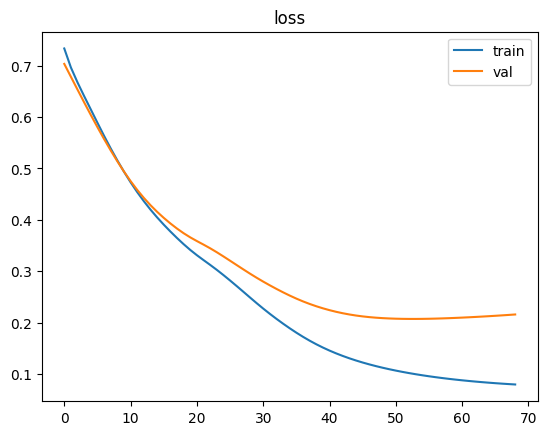

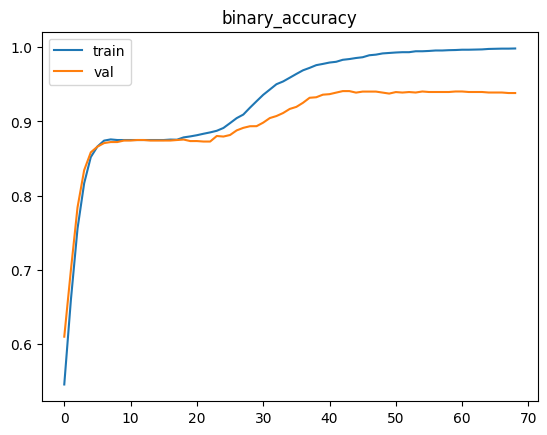

In [6]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [10]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.12482499940828844
train_binary_accuracy: 0.9830419475382025
loss: 0.21638516539877112
binary_accuracy: 0.9366883093660529


In [7]:
interpreter = LFCNNInterpreter(model, test, info)

In [ ]:
%matplotlib inline
for i in range(8):
    fig = interpreter.plot_branch(i, ['input', 'output', 'response', 'pattern'])
    plt.show()

In [10]:
params = LFCNNParameters(interpreter)

In [11]:
time_courses_filtered = interpreter.latent_sources_filtered[:, np.argsort(interpreter.branchwise_loss), :]

In [20]:
times = np.linspace(0, 1, time_courses_filtered.shape[-1])

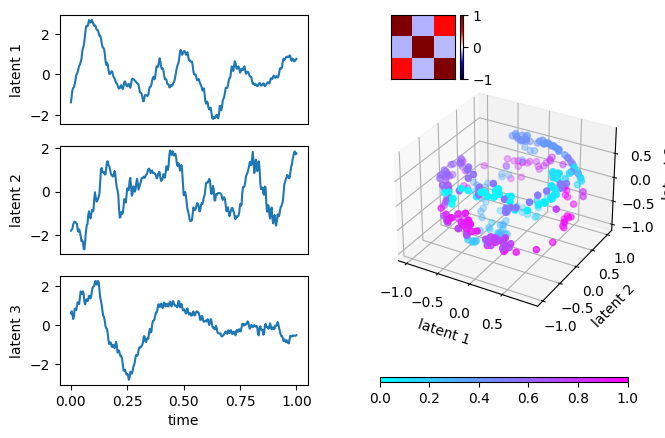

In [22]:
%matplotlib qt
plot_latent_space(
    sp.stats.zscore(time_courses_filtered.mean(0)[0]),
    sp.stats.zscore(time_courses_filtered.mean(0)[1]),
    sp.stats.zscore(time_courses_filtered.mean(0)[2]),
    times
)

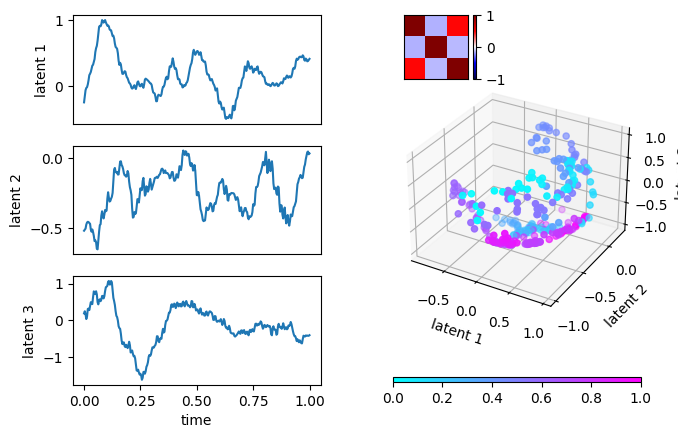

In [28]:
%matplotlib qt
plot_latent_space(
    time_courses_filtered.mean(0)[0],
    time_courses_filtered.mean(0)[1],
    time_courses_filtered.mean(0)[2],
    times
)

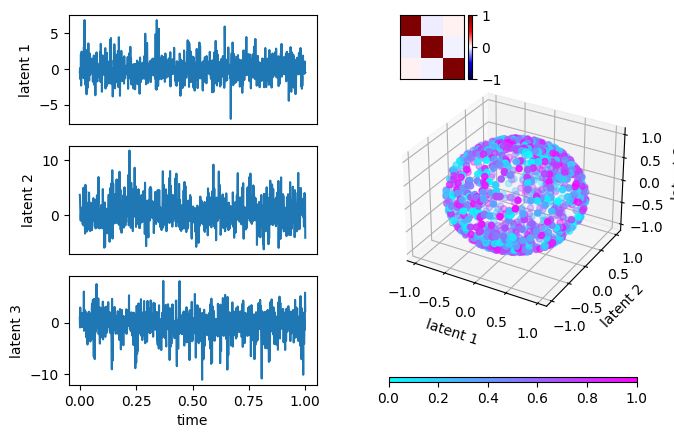

In [27]:
tc = np.reshape(np.transpose(time_courses_filtered, (-1, 0, 1)), (8, -1))[:, :1000]


plot_latent_space(
    tc[0],
    tc[1],
    tc[2],
    np.linspace(0, 1, tc.shape[-1])
)

In [22]:
model = LFCNN(
    n_channels=204, # ~ number of channels (gradiometers)
    n_latent=8, # ~ number of latent factors
    n_times=301, # ~ number of samples in epoch after preprocessing
    filter_size=50, # ~ FIR filter size
    pool_factor=10, # ~ take each 10th sample from spatially filtered components
    n_outputs=8 # ~ number of output classes (number of events in epochs)
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        TempConvAveClipping(),
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight', 'temp_conv.weight',
            ], lambdas=.01
        ), # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

In [23]:
if hasattr(sys.stdout, 'file'):
    sys.stdout = sys.stdout.file

In [24]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

Epoch 0:  loss_train:  0.7250   |    binary_accuracy_train:  0.5071   |    loss_val:  0.7080   |    binary_accuracy_val:  0.5918
Epoch 1:  loss_train:  0.6974   |    binary_accuracy_train:  0.6514   |    loss_val:  0.6846   |    binary_accuracy_val:  0.7080
Epoch 2:  loss_train:  0.6721   |    binary_accuracy_train:  0.7529   |    loss_val:  0.6614   |    binary_accuracy_val:  0.7885
Epoch 3:  loss_train:  0.6472   |    binary_accuracy_train:  0.8183   |    loss_val:  0.6384   |    binary_accuracy_val:  0.8412
Epoch 4:  loss_train:  0.6224   |    binary_accuracy_train:  0.8515   |    loss_val:  0.6154   |    binary_accuracy_val:  0.8612
Epoch 5:  loss_train:  0.5977   |    binary_accuracy_train:  0.8633   |    loss_val:  0.5925   |    binary_accuracy_val:  0.8695
Epoch 6:  loss_train:  0.5731   |    binary_accuracy_train:  0.8722   |    loss_val:  0.5698   |    binary_accuracy_val:  0.8722
Epoch 7:  loss_train:  0.5488   |    binary_accuracy_train:  0.8746   |    loss_val:  0.5475   | 

In [25]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.14709503271362998
train_binary_accuracy: 0.9767482497475364
loss: 0.23383840038017792
binary_accuracy: 0.9293831153349443


In [28]:
interpreter = LFCNNInterpreter(model, test, info)
params2 = LFCNNParameters(interpreter)


In [58]:
time_courses_filtered = params2.temporal.time_courses_filtered[:, np.argsort(params.order)[::-1], :]

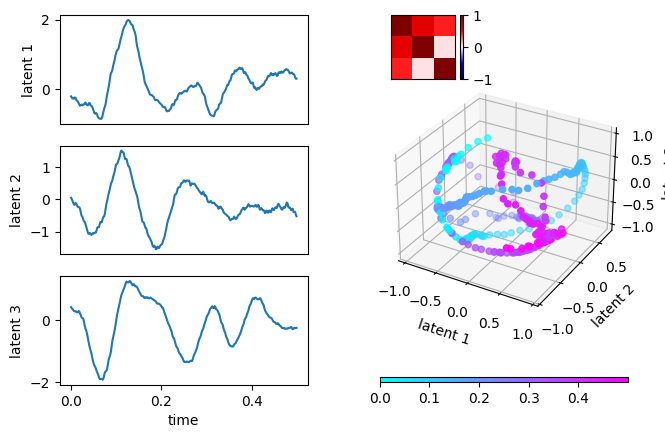

In [38]:
%matplotlib qt
plot_latent_space(
    time_courses_filtered.mean(0)[0],
    time_courses_filtered.mean(0)[1],
    time_courses_filtered.mean(0)[2],
    params.temporal.times
)

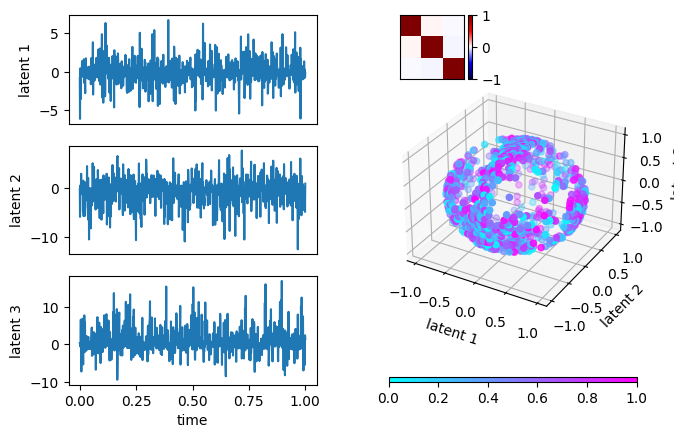

In [45]:
tc = np.reshape(np.transpose(time_courses_filtered, (-1, 0, 1)), (8, -1))[:, :1000]


plot_latent_space(
    tc[0],
    tc[1],
    tc[2],
    np.linspace(0, 1, tc.shape[-1])
)

/tmp/ipykernel_2328407/3296331998.py:11: RuntimeWarning: divide by zero encountered in divide
  s3 = np.sin(10/t)
/tmp/ipykernel_2328407/3296331998.py:11: RuntimeWarning: invalid value encountered in sin
  s3 = np.sin(10/t)


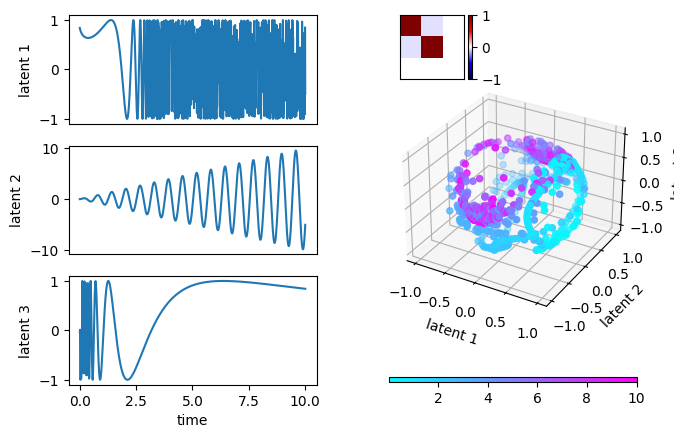

In [76]:
t = np.linspace(0, 10, 1000)

# s1 = np.sin(10*t) * np.exp(-(t - 5)**2/2)

# s2 = np.cos(10*t) * np.exp(-(t - 5)**2/10)

# s3 = np.sin(10*t + np.pi) * np.exp(-(t - 10)**2/1)

s1 = np.sin(t**t)
s2 = np.sin(10*t)*t
s3 = np.sin(10/t)

# s1 = np.random.random(len(t))-.5
# s2 = np.random.random(len(t))-.5
# s3 = np.random.random(len(t))-.5

# s1 = gaussian_random_walk(len(t))
# s2 = s1 #+ gaussian_random_walk(len(t))
# s3 = s1 #+ gaussian_random_walk(len(t))

plot_latent_space(s1, s2, s3, t)